# Naive bayes spam classifier

The task is:

* Write a model that will make predicts whether text is spam or not.
* Wrap the model in a service so that other services can communicate with the model - send messages to it and receive “spam / no spam” in response.
* Learn something new.

# How do spam filters work?

Let's see how most spam filters work and how their work is related to probability theory.

Most spam filters are based on the Bayesian theorem. It allows you to find the probability of one event, provided that another event has occurred. This is symbolically expressed as P(A|B), i.e. Probability of event A will occur given that event B has already occurred.
In our case, an event is the probability of meeting a text. Condition - the text is spam.


Reasons to use Bayes’ Theorem:

* Bayes’ Theorem provides a useful perspective for understanding and evaluating many learning algorithms.
* It calculates explicit probabilities for hypothesis and it is robust to noise in the input data.
* In statistical classification, it minimizes the probability of misclassification.

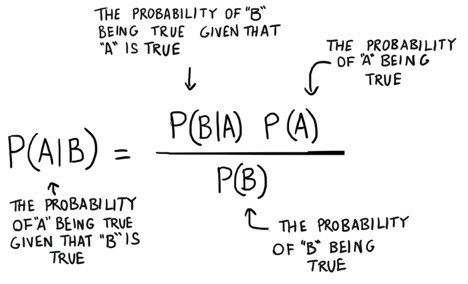

* P(A) - probability of spam
* P(B) - probability of text
* P(A|B) - probability that the text is spam
* P(B|A) - probability of meeting this text among spam

# How to count these probabilities?

The Bayesian classifier is based on the assumption that the attributes of a class are independent of each other. In reality, almost all attributes of anything depend on each other, and it is very naive to admit this. But with the classification of spam, the Bayesian algorithm is very effective (and this despite the fact that the words in the text always depend on each other). The fact is that in determining the “spam” nature of a text, we operate on probabilities. And if we believe that these probabilities are independent, we have a very powerful weapon - independent probabilities can be multiplied!

To calculate the probability that a given sentence is spam, we calculate the spam probability for each word in the sentence, and then simply multiply these probabilities. Thus, the likelihood that a given text is spam is the product of the probability of spam and the likelihood of encountering a given text among the set of all possible spam variants.


Thus, we calculate 
$$P(B|A) = \prod_{i} P(B_{i}|A)$$
* $\prod_{i}$ - product of several elements,
* $B$ - one sentence,
* $B_{i}$ - one word in sentense.

And then let's compute and compare the values of expressions. This inequality shows us, that given sentence is spam:
$$P(A|B) > P(\overline{A}|B)$$
* $P(\overline{A}|B)$ - probability that given sentence is not spam.

Or we could rewrite formula 
$$P(A) \cdot P(B|A) > P(\overline{A}) \cdot  P(B|\overline{A})$$


# Import

In [ ]:
import math
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Model
Let's create spam classificator

In [ ]:
# constant labels
SPAM = 'SPAM'
NOT_SPAM = 'NOT_SPAM'
MINIMUM_WORD_LENGTH = 0 # minimum controlled word length to exclude analysis of prepositions and articles


class SpamAnalizer():  
    def __init__(self):
        self.no_spam = {}  # dictionary with not spam words
        self.spam = {}     # dictionary with spam words
        self.pA = 0        # probability that the new mail is spam
        self.pNotA = 0     # probability that the new mail is not spam 
        self.spam_mails_count = 0       # spam mail counter during fitting
        self.notspam_mails_count = 0    # not spam mail counter during fitting
        self.mails_count = 0            # all types mail counter during fitting
#        self.fitting_word_counter = 0   # amount words in fitting dataset
        
    def calculate_word_frequencies(self, body, label):
        '''function is used in fitting
        function takes text labeled SPAM or NOT_SPAM and depending this label
        fills dictionaries self.no_spam and self.spam
        parameters: body - text, label - SPAM or NOT_SPAM
        '''
        
        # choosing filling dictionary
        if label == 'SPAM':
            current_dict = self.spam
        elif label == 'NOT_SPAM':
            current_dict = self.no_spam
        else:
            raise ValueError('Label should be "SPAM" or "NOT_SPAM"')
        
        # each word in body converted to lower case
        for word in body.lower().split():
        # using MINIMUM_WORD_LENGTH if we want to avoid processing prepositions
            if len(word) > MINIMUM_WORD_LENGTH:
                current_dict[word] = current_dict.get(word, 0) + 1
    
    def train(self, train_data):
        '''function is used in fitting
        function takes list of text labeled SPAM or NOT_SPAM and 
        calls calculate_word_frequencies for each text
        function fills values - different mail counters, self.pA, self.pNotA
        parameters: train_data - list of text
        '''
        for mail in train_data:
            self.mails_count += 1
            
            # deleting all characters except letters and spaces 
            pattern = re.compile('[^\sА-Яа-яёЁA-Za-z]')
            body = re.sub(pattern, '', mail[0])
            
            # filling self.spam_mails_count and self.notspam_mails_count
            # calling calculate_word_frequencies(..) for each text
            if str(mail[1]) == 'SPAM':
                self.spam_mails_count += 1
                self.calculate_word_frequencies(body, 'SPAM')
            elif str(mail[1]) == 'NOT_SPAM':
                self.notspam_mails_count += 1
                self.calculate_word_frequencies(body, 'NOT_SPAM')
            else:
                raise ValueError('Label should be "SPAM" or "NOT_SPAM"')
        
        # calculation self.pA and self.pNotA
        self.pA = self.spam_mails_count/self.mails_count
        self.pNotA = self.notspam_mails_count/self.mails_count
        
    def calculate_P_Bi_A(self, word, label):
        '''function considers for each word the probabilities that it is spam and that
        it is not spam due to label
        parameters: word - separate word, label - SPAM or NOT_SPAM
        output: how many times the word appeared in the corresponding dictionary(self.spam or self.no_spam)
        divided by the total number of unique words in the corresponding dictionary
        '''
        word_low = word.lower() # working with word only in lowcase
        
        # deciding wich dictionary we will use according label
        if label == 'SPAM':
            current_dict = self.spam
        elif label == 'NOT_SPAM':
            current_dict = self.no_spam
        else:
            raise ValueError('Label should be "SPAM" or "NOT_SPAM"')
        
       # counting probability that word is label category(SPAM or NOT_SPAM)
       # if we haven't seen yet this word during fitting, word counter is assigned 1, not 0
       # if we have seen this word during fitting, word counter is calculated in the corresponding dictionary

        word_probability = current_dict.get(word_low, 0) + 1
        
        # dividing number of word appearing in label category during fitting to the 
        # total number of unique words in the corresponding dictionary
        return(word_probability/sum(current_dict.values()))
    
    def calculate_P_B_A(self, text, label):
        '''function considers for text the probabilities that it is spam and that
        it is not spam due to label.
        According to Naive Bayes classifier probability that text belongs to label category is
        the sum of logarithm of probabilities that each word belongs to label category and 
        logarithm of probability meeting this label category among all fitting texts.
        
        parameters: text, label - SPAM or NOT_SPAM
        output: probability that text belongs to label category'''
        probability = 0
        
        # counting sum of logarithm of probabilities that each word belongs to label category
        # calling the function calculate_P_Bi_A for each word in text
        for word in text.split():
            if len(word) > MINIMUM_WORD_LENGTH:
                probability += math.log10(self.calculate_P_Bi_A(word, label))
        
        # adding logarithm of probability meeting this label category among all fitting texts
        if label == 'SPAM':
            probability += math.log10(self.pA)
        elif label == 'NOT_SPAM':
            probability += math.log10(self.pNotA)
        else:
            raise ValueError('Label should be "SPAM" or "NOT_SPAM"')
        
        return probability
    
    def classify(self, email):
        '''The function considers that email is SPAM or not calling the function calculate_P_B_A two 
        times with labels SPAM and NOT_SPAM and comparing results        
        '''
        # deleting all characters except letters and spaces
        pattern = re.compile('[^\sА-Яа-яёЁA-Za-z]')
        text = re.sub(pattern, '', email)
        
        # comparing probability that text is spam or not_spam
        if self.calculate_P_B_A(text, SPAM) > self.calculate_P_B_A(text, NOT_SPAM):
            return SPAM
        else:
            return NOT_SPAM


# First look

Let's test our classifier on small dataset(train_data) and some mail examples

In [ ]:
train_data = [  
    ['Купите новое чистящее средство', SPAM],   
    ['Купи мою новую книгу', SPAM],  
    ['Подари себе новый телефон', SPAM],
    ['Добро пожаловать и купите новый телевизор', SPAM],
    ['Привет давно не виделись', NOT_SPAM], 
    ['Довезем до аэропорта из пригорода всего за 399 рублей', SPAM], 
    ['Добро пожаловать в Мой Круг', NOT_SPAM],  
    ['Я все еще жду документы', NOT_SPAM],  
    ['Приглашаем на конференцию Data Science', NOT_SPAM],
    ['Потерял твой телефон напомни', NOT_SPAM],
    ['Порадуй своего питомца новым костюмом', SPAM]
]  

spam_analizer_test = SpamAnalizer()
spam_analizer_test.train(train_data)

In [ ]:
example_mail_1 = 'Развивай  купите бизнес на дому с услугой "Безлимитный Интернет"'
example_mail_2 = 'Мы получили ваше сообщение о пропаже багажа и домашнего питомца в здании аэропорта. Конечно, нам жаль. Но что мы можем с этим сделать?'
example_mail_3 = 'Перезвони по номеру +799999999 в течение 6 секунд и выиграй миллион рублей!'

print('mail_1 :',spam_analizer_test.classify(example_mail_1))
print('mail_2 :',spam_analizer_test.classify(example_mail_2))
print('mail_3 :',spam_analizer_test.classify(example_mail_3))
print()
print('minimum controlled word length: ', MINIMUM_WORD_LENGTH)
print('pA:', spam_analizer_test.pA)
print('unique spam words:', len(spam_analizer_test.spam))
print('unique not spam words:', len(spam_analizer_test.no_spam))


# Validation
I fitted model using dataset https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset

In [ ]:
# importing dataset https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset
# df = pd.read_csv('spam_or_not_spam.csv')
df = pd.read_csv("../input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
df = df.dropna()
df['label'] = df['label'].apply(lambda s: SPAM if (s == 1) else NOT_SPAM)

data_list = df.values.tolist()

In [ ]:
# Creating train and validation sets
train, valid = train_test_split(df, test_size=0.15, shuffle=True, random_state=42)

print('Initial dataset size: {}\nTrain set size: {}\nValidation set size: {}'
      .format(df.shape, train.shape, valid.shape)
)

In [ ]:
def visualize_train_valid_counts(init_data, train, valid):
    '''function create visualisation of splitted data
    in comparison with the initial data set
    '''
    x = np.array([0, 1])
    width = 0.2

    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    # classes in this example - SPAM or NOT_SPAM
    classes = list(init_data['label'].value_counts().index)

    ax.bar(x - width, list(init_data['label'].value_counts()[classes]), \
           width, color='r', label='Initial data set')
    ax.bar(x, list(train['label'].value_counts()[classes]), width, \
           color='g', label='Train set')
    ax.bar(x, list(valid['label'].value_counts()[classes]), width, \
           bottom=list(train['label'].value_counts()[classes]), \
           color='b', label='Validation set')


    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Samples', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)

In [ ]:
# let's look at the splitted data
visualize_train_valid_counts(df,train,valid)

In [ ]:
# fitting model with big dataset
train_list = train.values.tolist()

spam_analizer = SpamAnalizer()
spam_analizer.train(train_list)

In [ ]:
# creating information to analize accuracy score
valid['prediction'] = valid.apply(lambda row: spam_analizer.classify(row['email']), axis=1)

In [ ]:
valid[valid['label'] != valid['prediction']]

In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(valid['label'], valid['prediction'])
print('accuracy of model prediction:', score)

Our final result has accuracy 0.9755555555555555

# Fitting model and getting result

In [ ]:
spam_analizer = SpamAnalizer()
spam_analizer.train(data_list)

In [ ]:
example_mail_1 = "Hi, My name is Warren E. Buffett an American business magnate, investor and philanthropist. am the most successful investor in the world. I believe strongly in‘giving while living’ I had one idea that never changed in my mind? that you should use your wealth to help people and i have decided to give {$1,500,000.00} One Million Five Hundred Thousand United Dollars, to randomly selected individuals worldwide. On receipt of this email, you should count yourself as the lucky individual. Your email address was chosen online while searching at random. Kindly get back to me at your earliest convenience before i travel to japan for my treatment , so I know your email address is valid. Thank you for accepting our offer, we are indeed grateful You Can Google my name for more information: God bless you. Best Regard Mr.Warren E. Buffett Billionaire investor !"
example_mail_2 = "Hi guys I want to build a website like REDACTED and I wanted to get your perspective of whether that site is good from the users' perspective before I go ahead and build something similar. I think that the design of the site is very modern and nice but I am not sure how people would react to a similar site? I look forward to your feedback. Many thanks! "
example_mail_3 = "As a result of your application for the position of Data Engineer, I would like to invite you to attend an interview on May 30, at 9 a.m. at our office in Washington, DC. You will have an interview with the department manager, Moris Peterson. The interview will last about 45 minutes. If the date or time of the interview is inconvenient, please contact me by phone or email to arrange another appointment. We look forward to seeing you. "

print('mail_1 :',spam_analizer.classify(example_mail_1))
print('mail_2 :',spam_analizer.classify(example_mail_2))
print('mail_3 :',spam_analizer.classify(example_mail_3))
print()
print('minimum controlled word length: ', MINIMUM_WORD_LENGTH)
print('pA:', spam_analizer.pA)
print('unique spam words:', len(spam_analizer.spam))
print('unique not spam words:', len(spam_analizer.no_spam))
print('accuracy of model prediction:', score)